In [1]:
import numpy as np
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from concurrent.futures import ProcessPoolExecutor
import itertools
import joblib
import time
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy import ndimage

/work/08550/qz3485/miniconda3/envs/data_science/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Load and Preprocess the Data

Load the data. The time interval between each data is changed to 2 hours. 

The first dimension of the data is each satellite. 

The second dimension of the data is the time series over the month of Feburary. 

The third dimension of the data contains 10 physical quantities at each time point. 

- 0: time
- 1, 2, 3: 3D position 
- 4, 5, 6: 3D velocity
- 7, 8, 9: 3D angular momentum

In [2]:
starlink_data = np.load("starlink_data.npy")
print(starlink_data.shape)

# Slice to get a time interval of 2 hours
satellite_time = starlink_data[:, ::24, 0]
angular_momentum = starlink_data[:, ::24, 7:]
position = starlink_data[:, ::24, 1:4]

(1984, 8018, 10)


In [3]:
radius = np.linalg.norm(position, ord=2, axis=2)
angular_momentum_mag = np.linalg.norm(angular_momentum, ord=2, axis=2)

# Change the time points to the days of the month of Feburary
satellite_time = (satellite_time - 2022*10**9)*10**-6
satellite_time = satellite_time - np.min(satellite_time[:, 0:1])

Smooth the data using a moving average.

In [4]:
for i in range(position.shape[0]):
    # Find the first index that has a value of nan. 
    if np.isnan(position[i, -1, 0]):
        nan_index = np.argwhere(np.isnan(position[i, :, 0]))[0][0]
    else:
        nan_index = position.shape[1]

    # The moving average is done on the data without the nan values. 
    angular_momentum[i, :nan_index, :] = ndimage.uniform_filter1d(angular_momentum[i, :nan_index, :], size=50, axis=0)
    radius[i, :nan_index] = ndimage.uniform_filter1d(radius[i, :nan_index], size=50, axis=0)
    angular_momentum_mag[i, :nan_index] = ndimage.uniform_filter1d(angular_momentum_mag[i, :nan_index], size=50, axis=0)

Center the data to 0 rowise by subtracting the mean. 

In [5]:
normed_angular_momentum = angular_momentum - np.nanmean(angular_momentum, axis=1, keepdims=True)
normed_radius = (radius - np.nanmean(radius, axis=1, keepdims=True))[:, :, None]
normed_angular_momentum_mag = (angular_momentum_mag - np.nanmean(angular_momentum_mag, axis=1, keepdims=True))[:, :, None]

print(satellite_time.shape)
print(normed_angular_momentum.shape)
print(normed_angular_momentum_mag.shape)
print(normed_radius.shape)

(1984, 335)
(1984, 335, 3)
(1984, 335, 1)
(1984, 335, 1)


# Visualize the Data

Plot the 3D angular momentum at the first time point. 

In [27]:
def plot_3d(time_point: int, 
            data: np.ndarray, 
            ax: plt.Axes, 
            cluster_labels: np.ndarray = None, 
            num_cluster: int = None):
    '''
    Plot 3D time-series data at a specific time point
    The data points can be colored with cluster labels
    '''

    plt.cla()
    if cluster_labels is None:
        ax.scatter(data[:, time_point, 0], 
            data[:, time_point, 1], 
            data[:, time_point, 2], 
            s = 40)
    else:
        for i in range(num_cluster):
            ax.scatter(data[cluster_labels == i][:, time_point, 0], 
                        data[cluster_labels == i][:, time_point, 1], 
                        data[cluster_labels == i][:, time_point, 2], 
                        s = 40, 
                        label = "Cluster " + str(i))
            ax.legend()

    ax.set_xlabel('h_x')
    ax.set_ylabel('h_y')
    ax.set_zlabel('h_z')
    ax.set_xlim([-50000, 50000])
    ax.set_ylim([-50000, 50000])
    ax.set_zlim([30500, 32000])

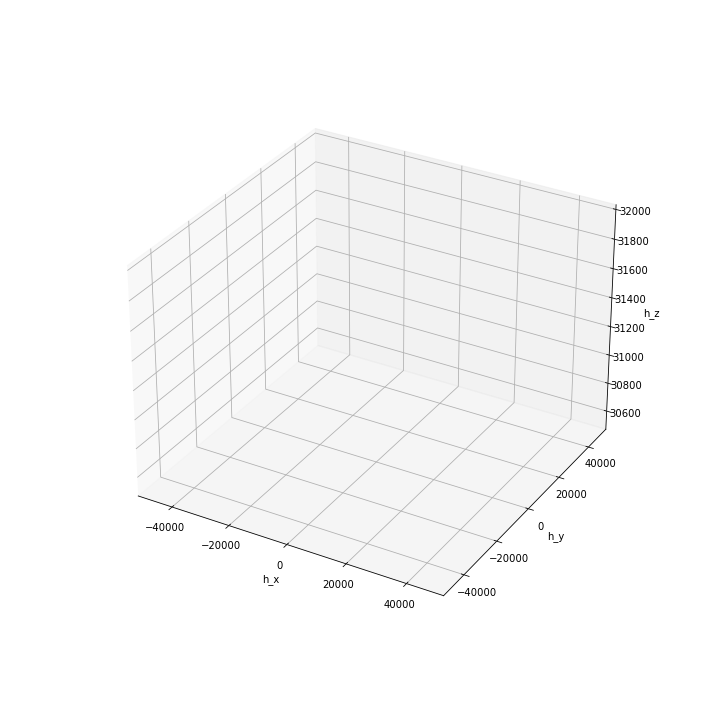

In [29]:
%matplotlib widget

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
plot_3d(0, normed_angular_momentum, ax)
plt.ion()
plt.show()

Plot a couple time-series data for angular momentum. 

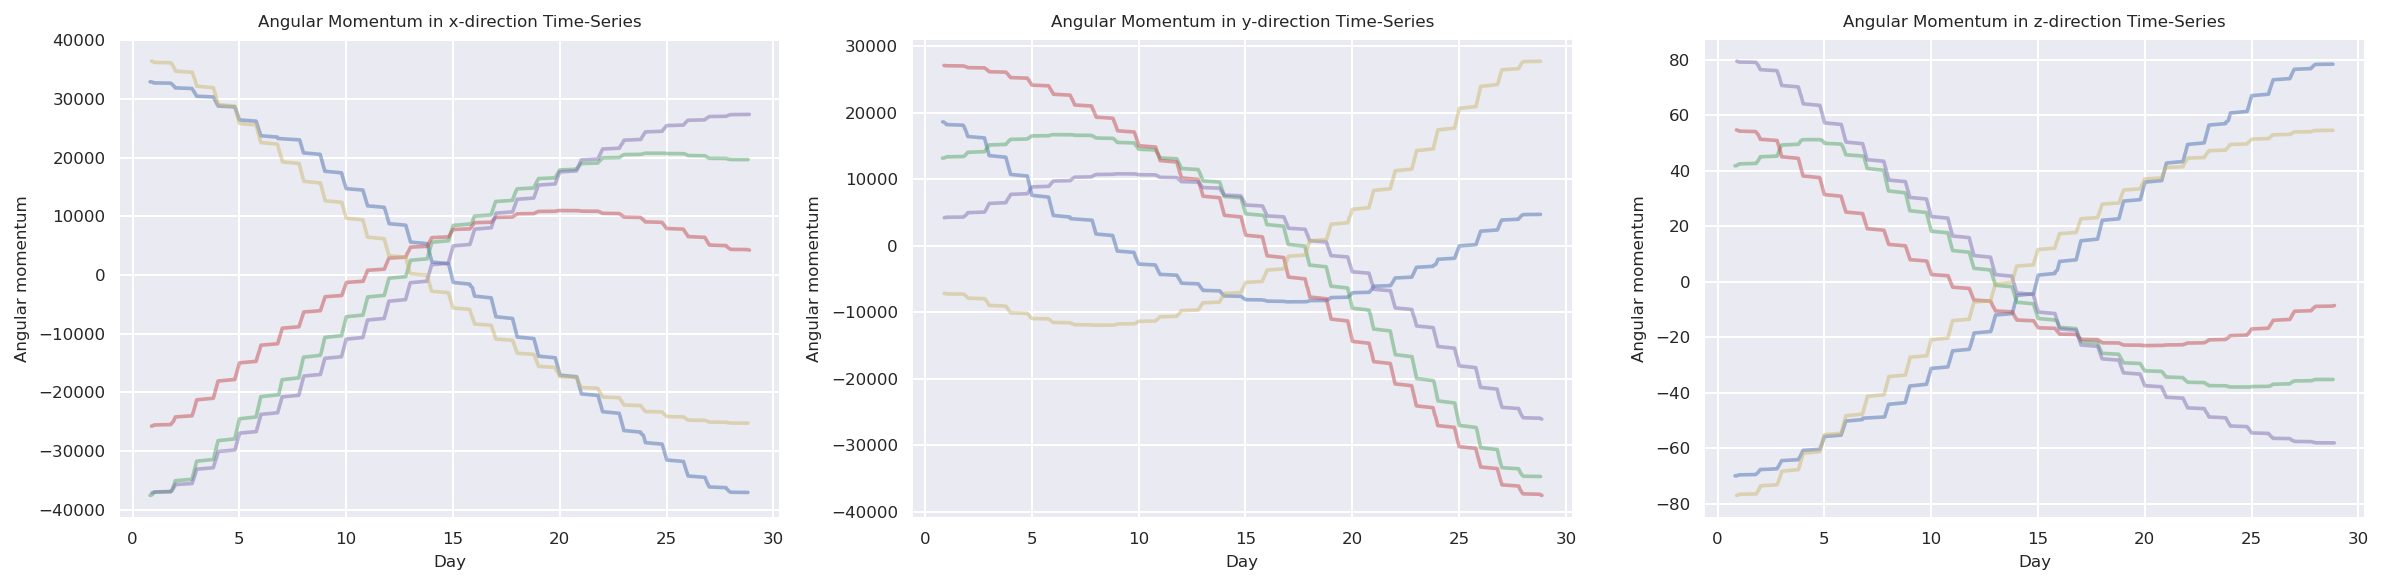

In [28]:
%matplotlib inline

plt.figure(figsize=(16, 4), dpi=150)
with plt.style.context("seaborn"):
    for i in range(3):
        plt.subplot(1, 3, i+1)
        for j, ts in enumerate(normed_angular_momentum[::400, :, :]):
            plt.plot(satellite_time[::400, :][j], ts[:, i], alpha=0.5)

        if i == 0:
            plt.title("Angular Momentum in x-direction Time-Series", fontsize=8)
        elif i == 1:
            plt.title("Angular Momentum in y-direction Time-Series", fontsize=8)
        elif i == 2:
            plt.title("Angular Momentum in z-direction Time-Series", fontsize=8)
        
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        plt.xlabel("Day", fontsize=8)
        plt.ylabel("Angular momentum", fontsize=8)

plt.tight_layout()
plt.show()

Plot a couple time-series data for radius. 

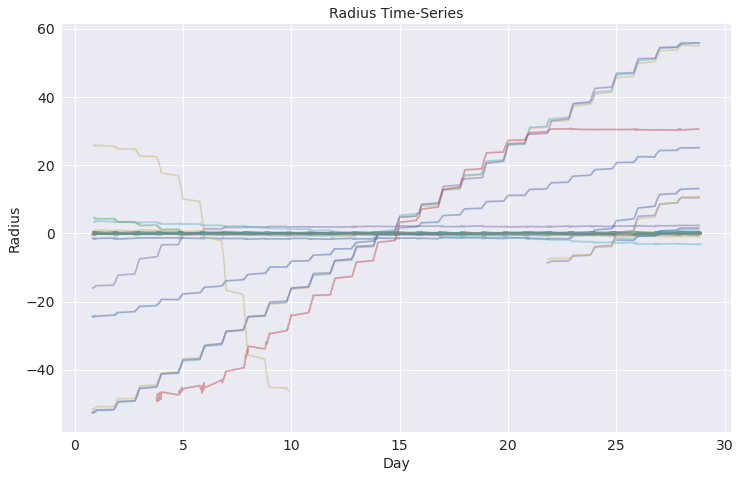

In [29]:
%matplotlib inline

plt.figure(figsize=(12, 7.5))
with plt.style.context("seaborn"):
    for i, ts in enumerate(normed_radius[::30, :]):
        plt.plot(satellite_time[::30, :][i], ts, alpha=0.5)
plt.title("Radius Time-Series", fontsize=14)
plt.xlabel("Day", fontsize=14)
plt.ylabel("Radius", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Plot a couple time-series data for magniude of angular momentum. 

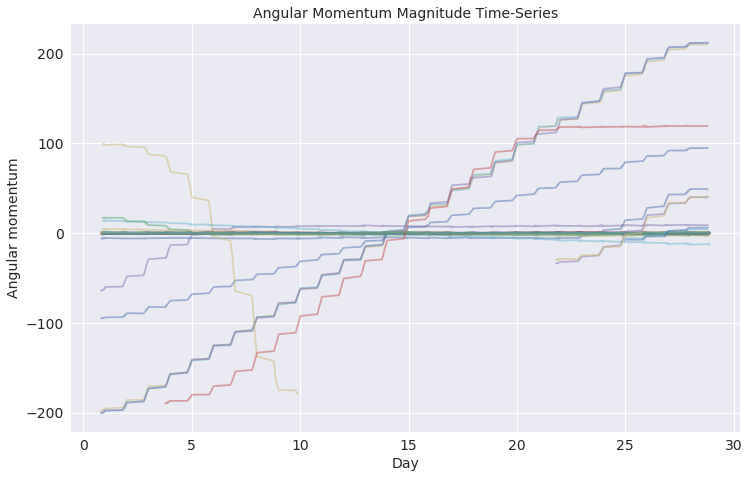

In [30]:
%matplotlib inline

plt.figure(figsize=(12, 7.5))
with plt.style.context("seaborn"):
    for i, ts in enumerate(normed_angular_momentum_mag[::30, :]):
        plt.plot(satellite_time[::30, :][i], ts, alpha=0.5)
plt.title("Angular Momentum Magnitude Time-Series", fontsize=14)
plt.xlabel("Day", fontsize=14)
plt.ylabel("Angular momentum", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Clustering Model

In [8]:
def ts_kmeans_func(data: np.ndarray, num_cluster: int, data_name: str):
    start_time = time.time()
    ts_kmeans = TimeSeriesKMeans(n_clusters=num_cluster, 
                                metric="dtw", 
                                random_state=0, 
                                n_jobs=-1).fit(data)
    
    cluster_labels = ts_kmeans.labels_
    score = silhouette_score(data, 
                        cluster_labels, 
                        metric="dtw", 
                        n_jobs=-1,
                        random_state=0)
                                
    print("Data:", data_name, 
            "| Num cluster:", num_cluster, 
            "| Sum of squares:", ts_kmeans.inertia_, 
            "| Silhouette Score:", score,
            "| Elapsed time:", time.time()-start_time)
            
    return ts_kmeans, score

def ts_kmeans_elbow(data: np.ndarray, num_cluster: int, data_name: str):
    '''
    Calculates the sum of squares and silhouette score for different number of clusters using time-series K-means.
    The elbow method is used to select an optimal number of cluster for sum of squares.
    Parallized model fitting over each number of cluster. 
    Save all of the models. 
    '''
    cluster_list = range(2, num_cluster+1)
    multiprocessing_data = itertools.repeat(data, len(cluster_list))
    data_name_list = itertools.repeat(data_name, len(cluster_list))

    with ProcessPoolExecutor(max_workers=len(cluster_list)) as pool:
        ts_kmeans_list = list(pool.map(ts_kmeans_func, multiprocessing_data, cluster_list, data_name_list))

    sum_squares = [val[0].inertia_ for val in ts_kmeans_list]
    silhouette_score_list = [val[1] for val in ts_kmeans_list]
    print()
    plt.figure(figsize=(12, 7.5))
    with plt.style.context("seaborn"):
        plt.plot(cluster_list, sum_squares)
    plt.title("Sum of squares for 10 clusters for " + data_name.replace("_", " "), fontsize=14)
    plt.ylabel('Sum of Squares', fontsize=14)
    plt.xlabel('Number of clusters', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig("sum_squares_" + data_name + ".png", facecolor='white')
    plt.show()

    plt.figure(figsize=(12, 7.5))
    with plt.style.context("seaborn"):
        plt.plot(cluster_list, silhouette_score_list)
    plt.title("Silhouette score for 10 clusters for " + data_name.replace("_", " "), fontsize=14)
    plt.ylabel('Silhouette Score', fontsize=14)
    plt.xlabel('Number of clusters', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig("silhouette_score_" + data_name + ".png", facecolor='white')
    plt.show()

    joblib.dump([val[0] for val in ts_kmeans_list], "ts_kmeans_" + data_name + ".joblib")

Apply time-series k-means clustering to all 3 directions of angular momentum. 

Data: radius | Num cluster: 5 | Sum of squares: 204.36930696906046 | Silhouette Score: 0.9053040637421889 | Elapsed time: 1156.6984984874725
Data: angular_momentum | Num cluster: 2 | Sum of squares: 24266041053.0482 | Silhouette Score: 0.38405433217461404 | Elapsed time: 1165.0380504131317
Data: angular_momentum_magnitude | Num cluster: 4 | Sum of squares: 14238.328308337943 | Silhouette Score: 0.843150575337239 | Elapsed time: 1195.2515215873718
Data: radius | Num cluster: 4 | Sum of squares: 261.9721146495878 | Silhouette Score: 0.9211804250901252 | Elapsed time: 1202.870130777359
Data: angular_momentum_magnitude | Num cluster: 3 | Sum of squares: 14982.212004746485 | Silhouette Score: 0.8557727535853316 | Elapsed time: 1216.7961831092834
Data: angular_momentum | Num cluster: 5 | Sum of squares: 7243093508.9038515 | Silhouette Score: 0.5070315303636949 | Elapsed time: 1250.534283399582
Data: angular_momentum_magnitude | Num cluster: 6 | Sum of squares: 1289.6085791199664 | Silhouette

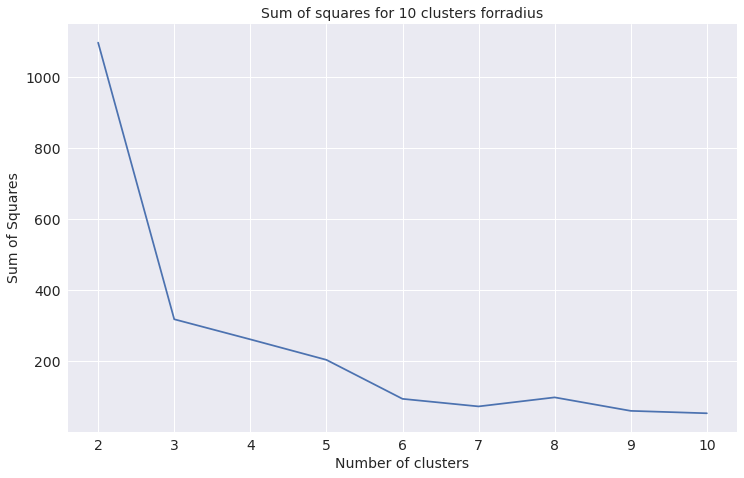

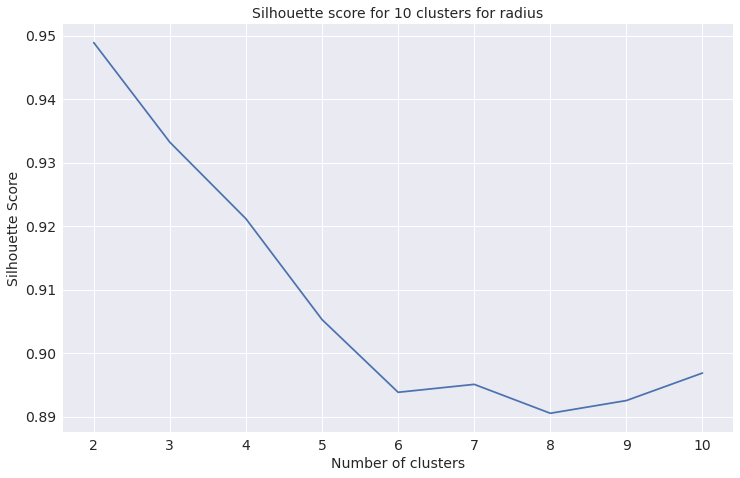

Data: angular_momentum_magnitude | Num cluster: 9 | Sum of squares: 593.0387094417789 | Silhouette Score: 0.9097528834340792 | Elapsed time: 2110.5646798610687



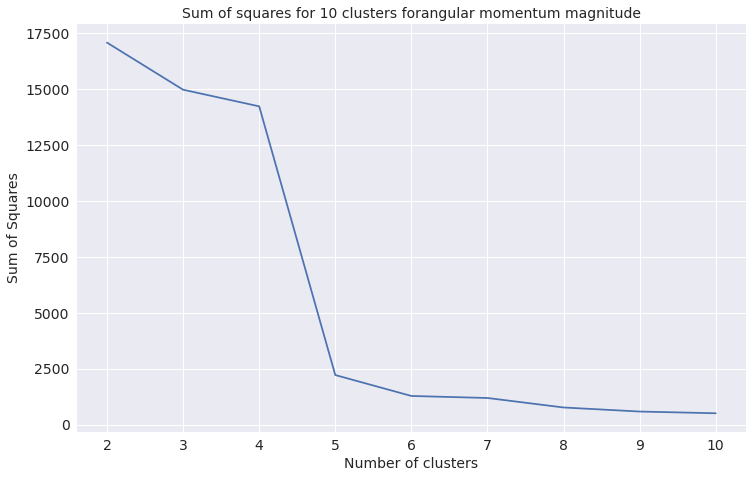

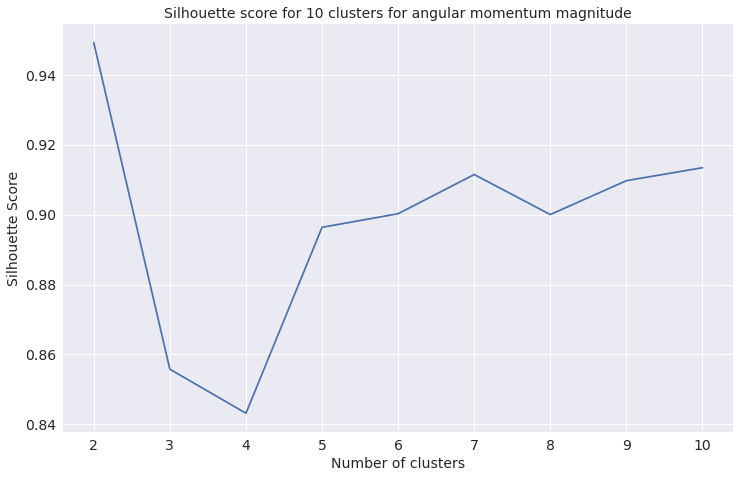

Data: angular_momentum | Num cluster: 9 | Sum of squares: 3036154110.722934 | Silhouette Score: 0.5378704965087252 | Elapsed time: 2343.358428955078
Data: angular_momentum | Num cluster: 10 | Sum of squares: 2432686958.3132114 | Silhouette Score: 0.5403887870194123 | Elapsed time: 2422.7751083374023



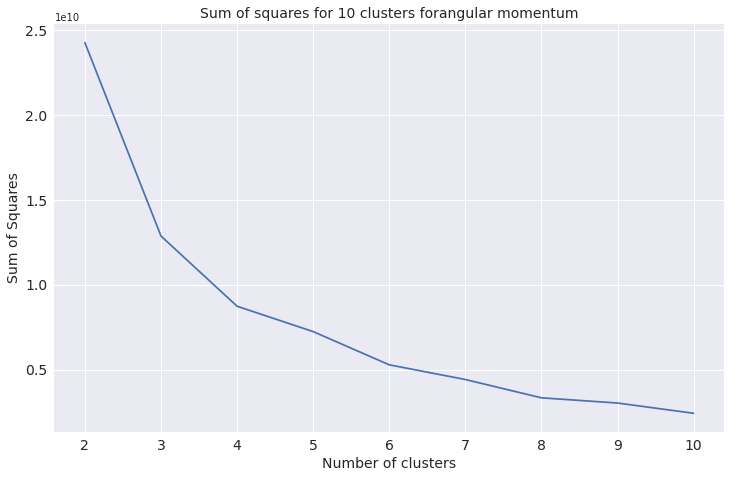

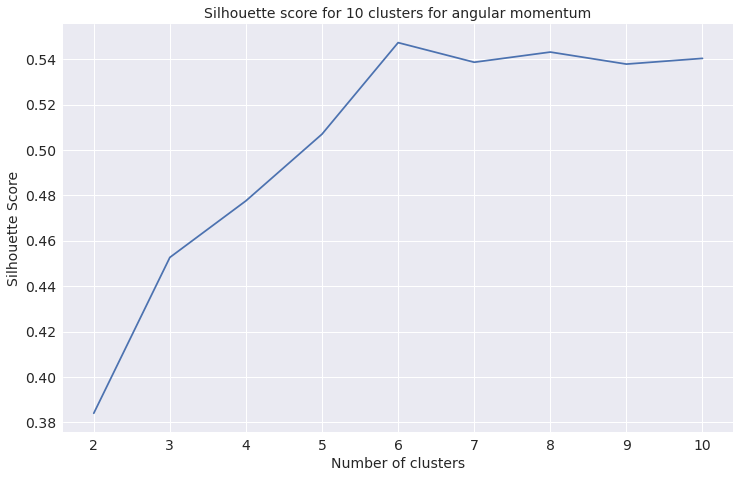

In [9]:
%matplotlib inline

with ProcessPoolExecutor(max_workers=3) as outer_pool:
    multiprocessing_data = [normed_angular_momentum, normed_radius, normed_angular_momentum_mag]
    data_name = ["angular_momentum", "radius", "angular_momentum_magnitude"]
    num_cluster = 10
    outer_pool.map(ts_kmeans_elbow, multiprocessing_data, itertools.repeat(num_cluster, 3), data_name)

# Clustering Result

In [13]:
def load_ts_kmeans_model(ts_kmeans_model: TimeSeriesKMeans, data: np.ndarray): 
    '''
    Get the cluster information from a time-series kmeans model
    '''
    cluster_labels = ts_kmeans_model.labels_
    
    optimal_cluster, counts = np.unique(cluster_labels, return_counts=True)
    optimal_cluster_num = len(optimal_cluster)
    for i, val in enumerate(counts):
        print("Size of Cluster " + str(i), val)

    cluster_centers = np.zeros(ts_kmeans_model.cluster_centers_.shape)
    for i in range(optimal_cluster_num):
        cluster_centers[i] = np.nanmean(data[cluster_labels==i], axis=0)

    # cluster_centers = ts_kmeans_model.cluster_centers_

    return optimal_cluster_num, cluster_labels, cluster_centers

In [14]:
def ts_cluster_plot(time: np.ndarray, 
                    data: np.ndarray, 
                    num_cluster: int, 
                    cluster_labels: np.ndarray, 
                    cluster_centers: np.ndarray, 
                    dimension: int):
    '''
    Plot the time-series data and the cluster center in each cluster. 
    '''
    for i in range(num_cluster):
        # Plot all the clusters in a subplot if there is only 1 quantity at each time point
        if dimension == 1:
            plt.subplot(num_cluster//3+1, 3, i+1)
            
            # Plot the same number of time-series for different-sized clusters
            data_cluster_i = data[cluster_labels == i]
            step = max(data_cluster_i.shape[0]//20, 1)
            for j, ts in enumerate(data_cluster_i[::step, :]):
                plt.plot(time[::step, :][j], ts, "k-", linewidth=0.1)

            plt.plot(time[0, :], cluster_centers[i, :], "r-")

            plt.title("Cluster " + str(i+1))
            plt.xticks(fontsize=8)
            plt.yticks(fontsize=8)
            plt.xlabel("Day", fontsize=8)
        # If there are multiple quantities at a point time, 
        # plot 1 cluster on each row of subplot with each quantity in a column
        else:
            for j in range(dimension):
                plt.subplot(num_cluster, dimension, i*dimension+j+1)
                
                data_cluster_i = data[cluster_labels == i]
                step = max(data_cluster_i.shape[0]//20, 1)
                for k, ts in enumerate(data_cluster_i[::step, :, j]):
                    plt.plot(time[::step, :][k], ts, "k-", linewidth=0.1)

                plt.plot(time[0, :], cluster_centers[i, :, j], "r-")

                plt.xticks(fontsize=8)
                plt.yticks(fontsize=8)
                plt.xlabel("Day", fontsize=8)

                if i == 0 and j == 0:
                    plt.title("Angular Momentum in x-direction", fontsize=8)
                elif i == 0 and j == 1:
                    plt.title("Angular Momentum in y-direction", fontsize=8)
                elif i == 0 and j == 2:
                    plt.title("Angular Momentum in z-direction", fontsize=8)
            plt.figtext(0.5, 1-(i*(1/num_cluster)+0.01), "Cluster " + str(i+1))

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    plt.show()

Load the optimal model by selecting a number of cluster for angular momentum. 

Size of Cluster 0 398
Size of Cluster 1 528
Size of Cluster 2 510
Size of Cluster 3 418
Size of Cluster 4 130


/tmp/ipykernel_384694/4150278562.py:14: RuntimeWarning: Mean of empty slice
  cluster_centers[i] = np.nanmean(data[cluster_labels==i], axis=0)


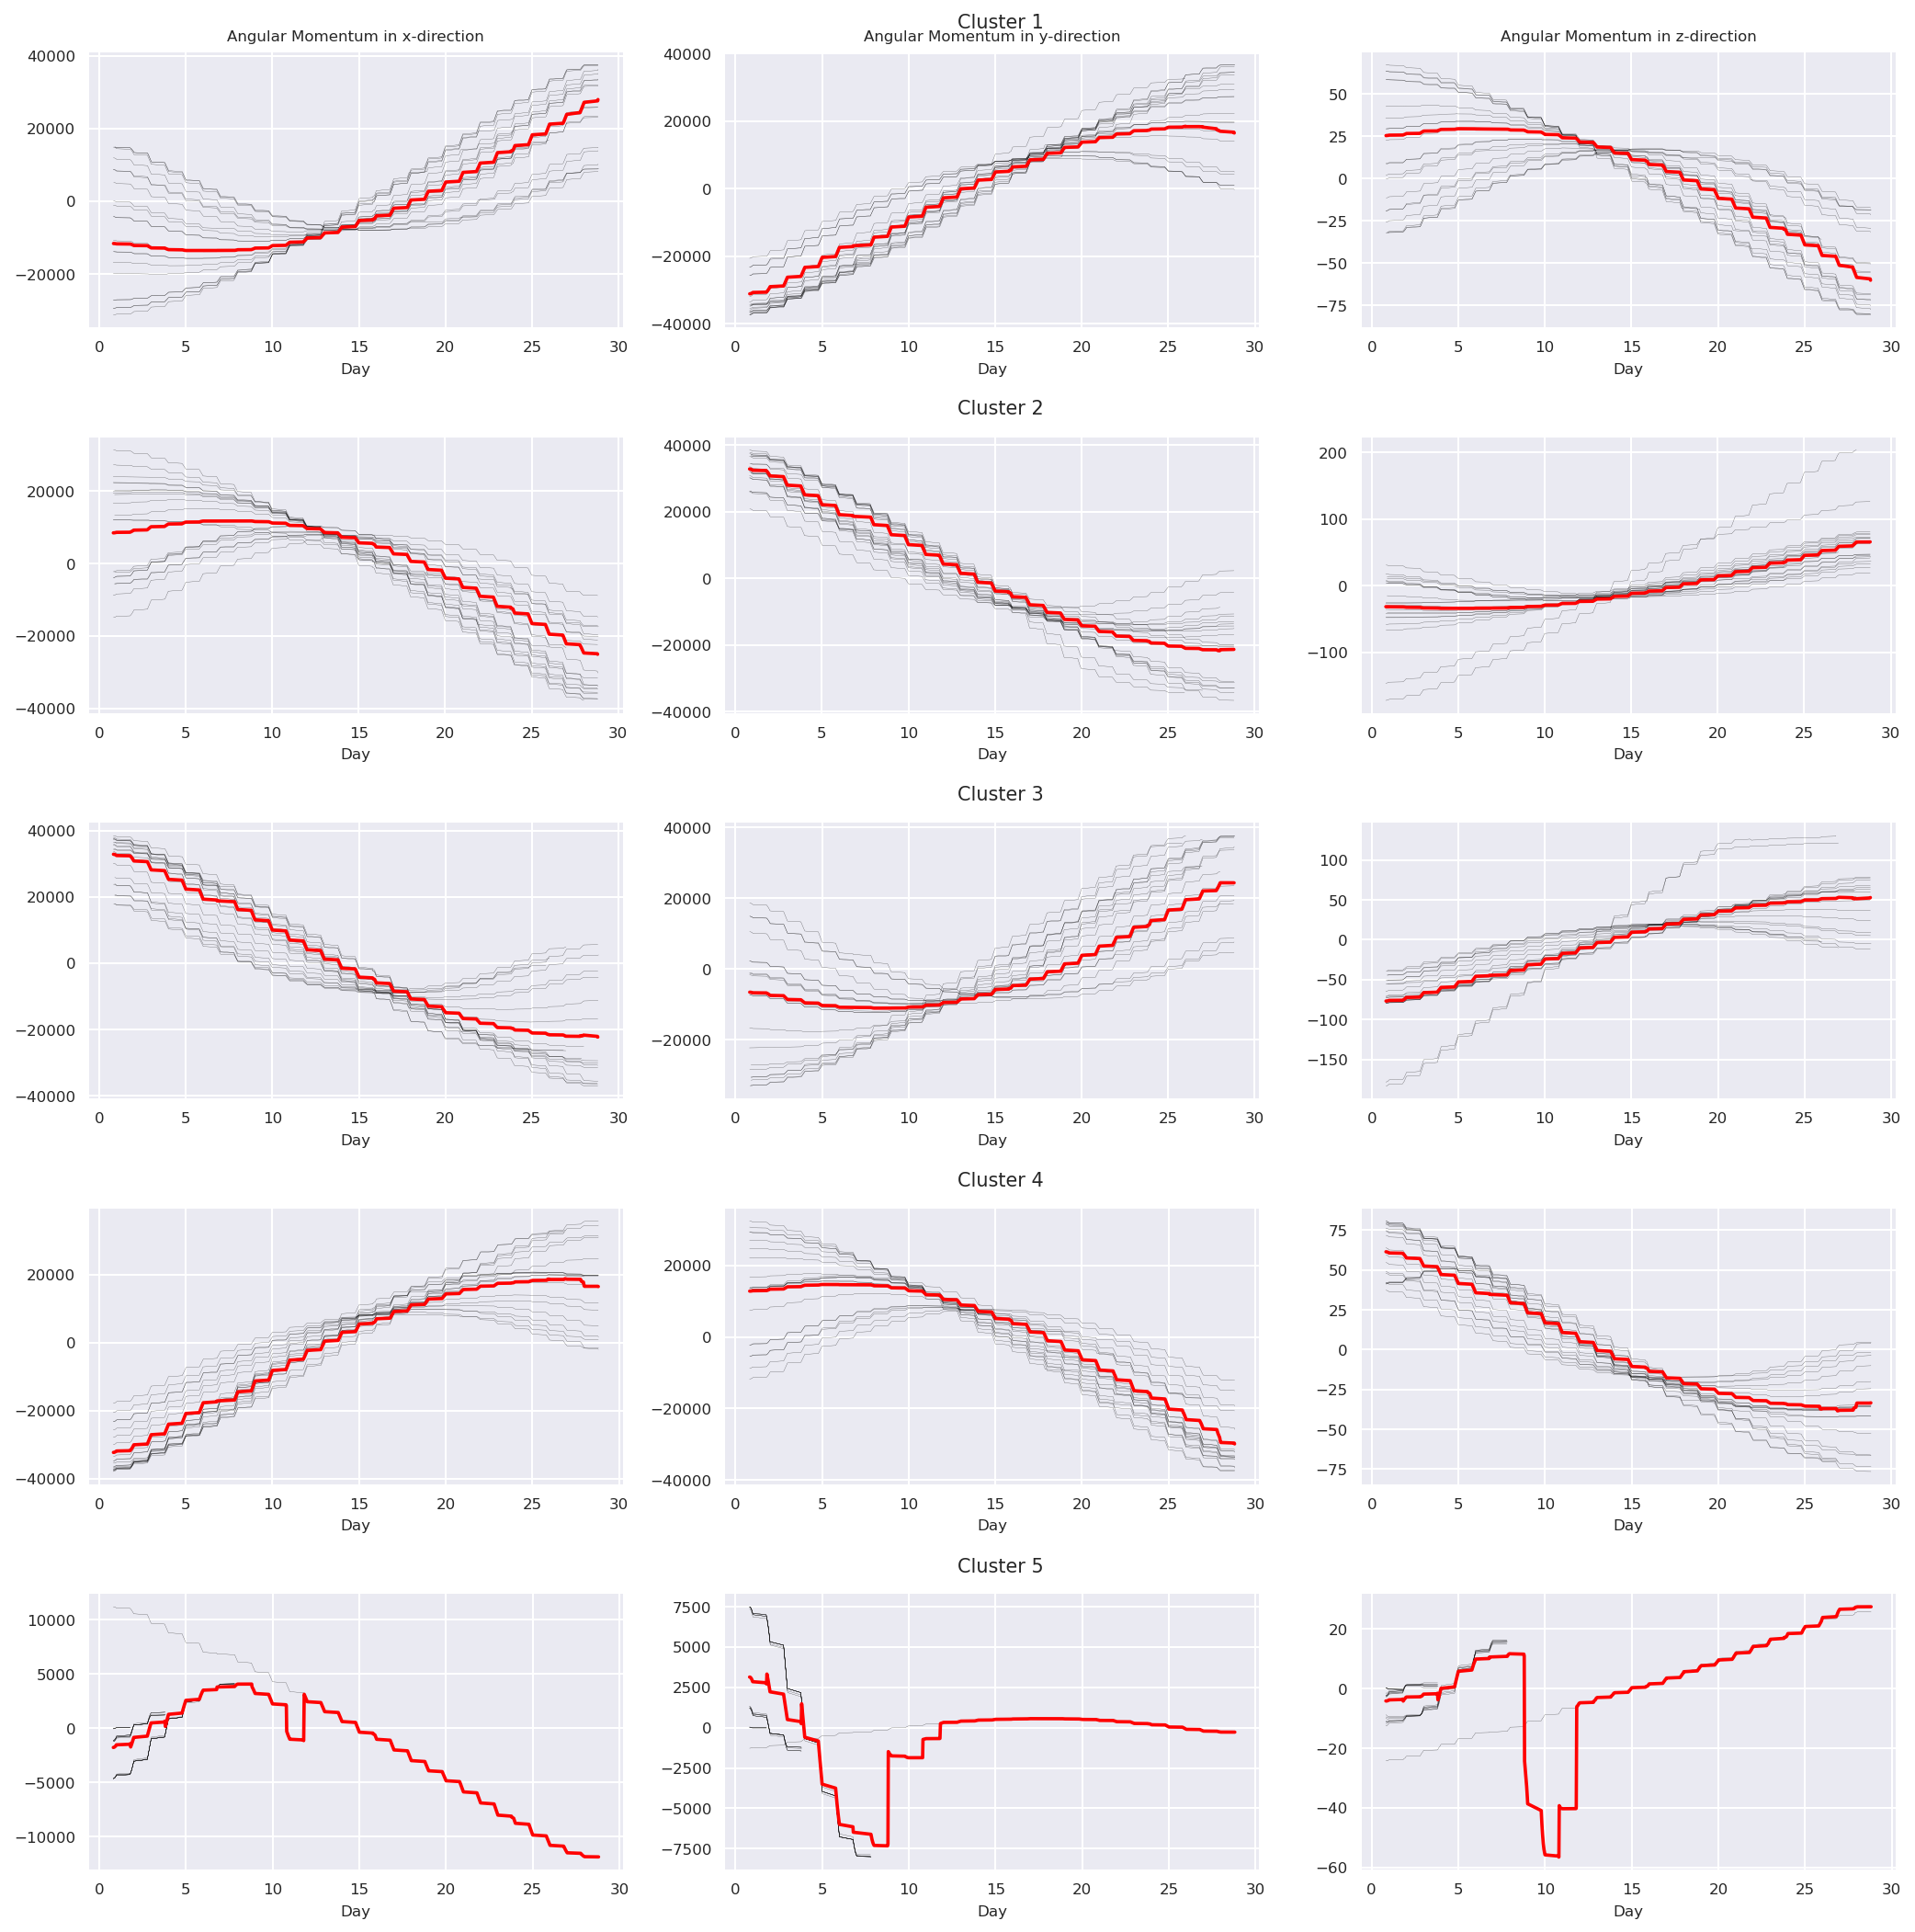

In [15]:
%matplotlib inline

optimal_cluster = 5
ts_kmeans_angular_momentum = joblib.load('ts_kmeans_angular_momentum.joblib')[optimal_cluster-2]
optimal_cluster_AM, cluster_labels_AM, cluster_centers_AM = load_ts_kmeans_model(ts_kmeans_angular_momentum, normed_angular_momentum)

plt.figure(figsize=(14, 14), dpi=150)
with plt.style.context("seaborn"):
    ts_cluster_plot(satellite_time,
                    normed_angular_momentum, 
                    optimal_cluster_AM, 
                    cluster_labels_AM, 
                    cluster_centers_AM, 
                    3)

Load the optimal model by selecting a number of cluster for radius. 

Size of Cluster 0 1812
Size of Cluster 1 138
Size of Cluster 2 34


/tmp/ipykernel_384694/4150278562.py:14: RuntimeWarning: Mean of empty slice
  cluster_centers[i] = np.nanmean(data[cluster_labels==i], axis=0)


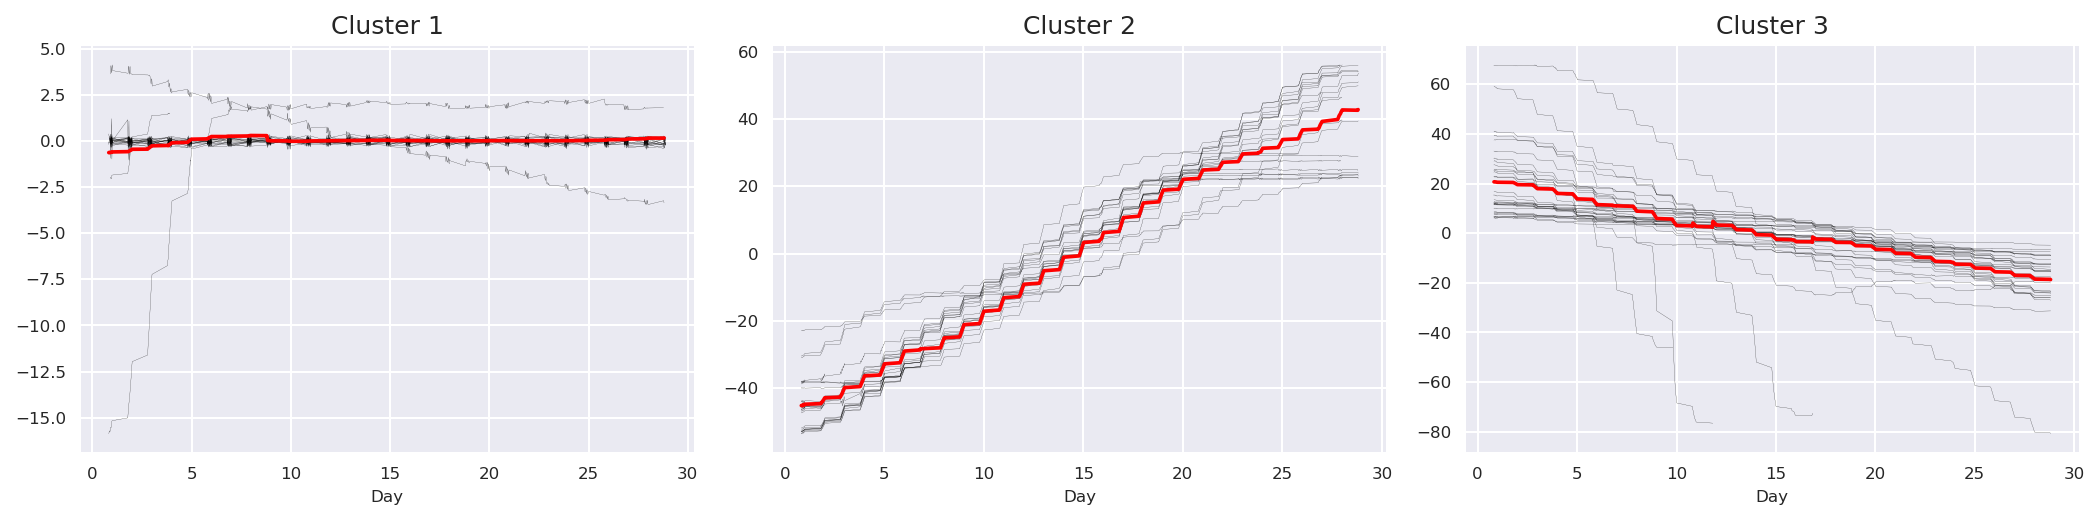

In [16]:
%matplotlib inline

optimal_cluster = 3
ts_kmeans_radius = joblib.load('ts_kmeans_radius.joblib')[optimal_cluster-2]
optimal_cluster_R, cluster_labels_R, cluster_centers_R = load_ts_kmeans_model(ts_kmeans_radius, normed_radius)

plt.figure(figsize=(14, 7), dpi=150)
with plt.style.context("seaborn"):
    ts_cluster_plot(satellite_time,
                    normed_radius, 
                    optimal_cluster_R, 
                    cluster_labels_R, 
                    cluster_centers_R, 
                    1)

Apply time-series k-means clustering to the magnitude of angular momentum. 

Size of Cluster 0 1702
Size of Cluster 1 40
Size of Cluster 2 82
Size of Cluster 3 54
Size of Cluster 4 5
Size of Cluster 5 30
Size of Cluster 6 71


/tmp/ipykernel_259051/4150278562.py:14: RuntimeWarning: Mean of empty slice
  cluster_centers[i] = np.nanmean(data[cluster_labels==i], axis=0)


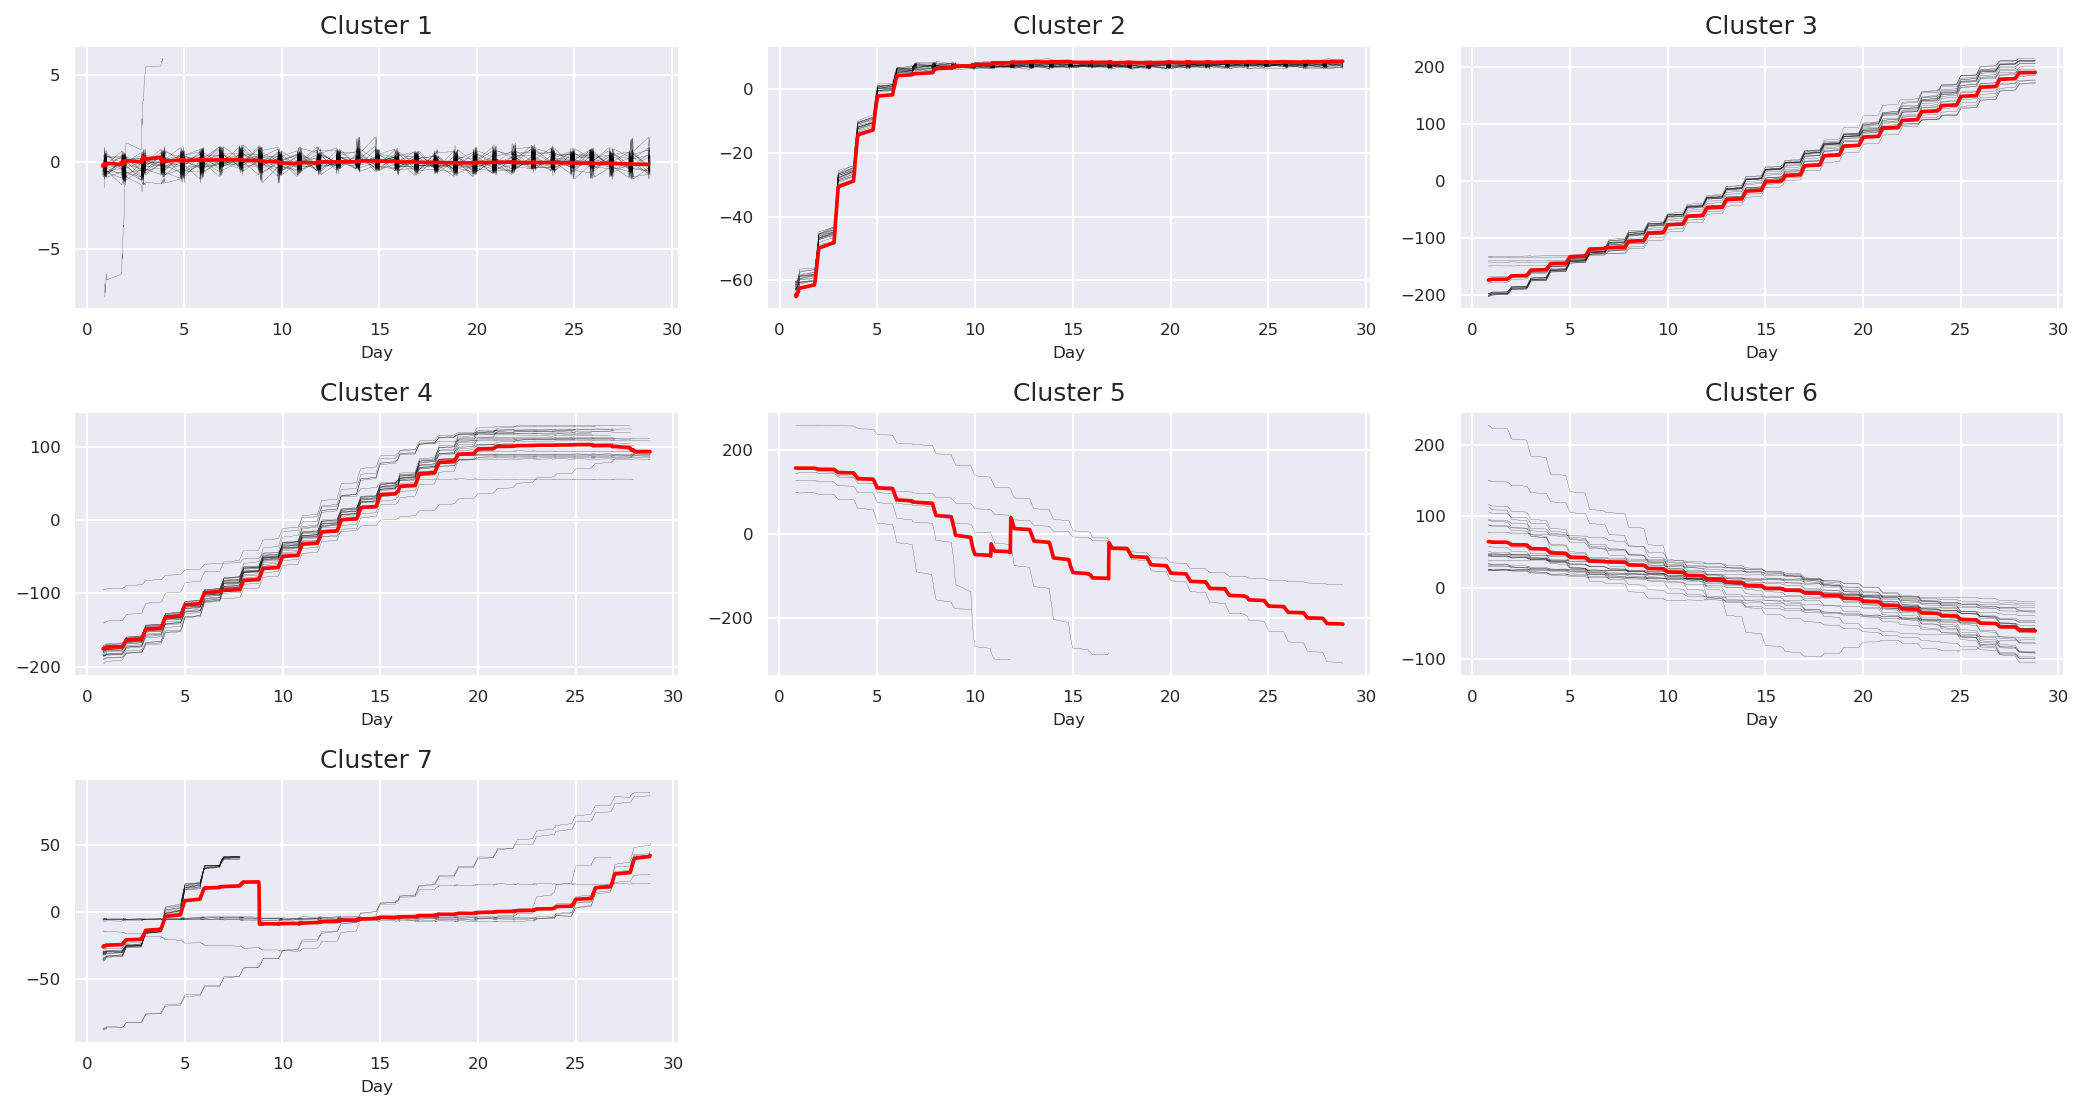

In [96]:
%matplotlib inline

optimal_cluster = 7
ts_kmeans_angular_momentum_mag = joblib.load('ts_kmeans_angular_momentum_magnitude.joblib')[optimal_cluster-2]
optimal_cluster_AM_mag, cluster_labels_AM_mag, cluster_centers_AM_mag = load_ts_kmeans_model(ts_kmeans_angular_momentum_mag, normed_angular_momentum_mag)

plt.figure(figsize=(14, 7.5), dpi=150)
with plt.style.context("seaborn"):
    ts_cluster_plot(satellite_time,
                    normed_angular_momentum_mag, 
                    optimal_cluster_AM_mag, 
                    cluster_labels_AM_mag, 
                    cluster_centers_AM_mag, 
                    1)

Show the clustering of the data at the 0 time point. 

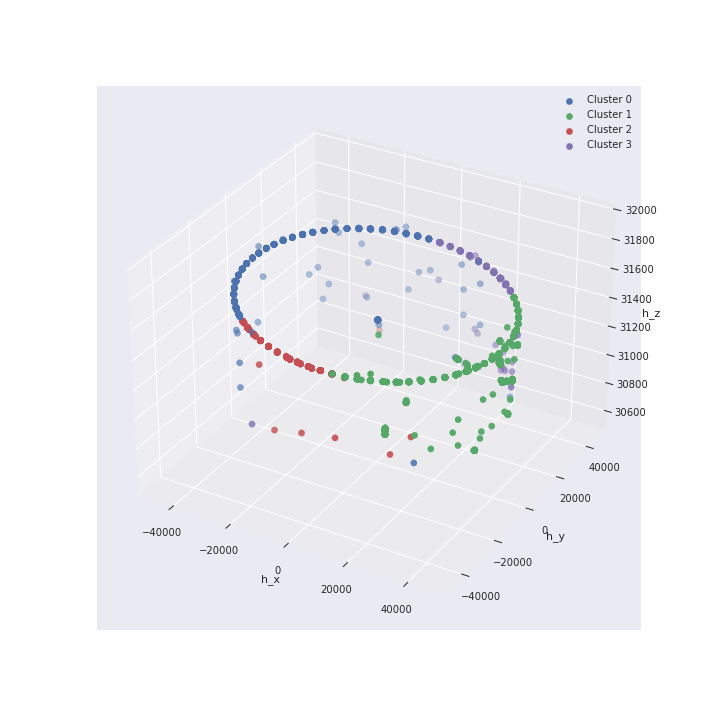

In [51]:
%matplotlib widget

fig2 = plt.figure(figsize = (10, 10))
ax2 = fig2.add_subplot(111, projection='3d')
plot_3d(0, angular_momentum, ax2, cluster_labels_AM, optimal_cluster_AM)
plt.ion()
plt.show()

Create an animation of the evolution of angular momentum with the cluster labelled for each data point. 

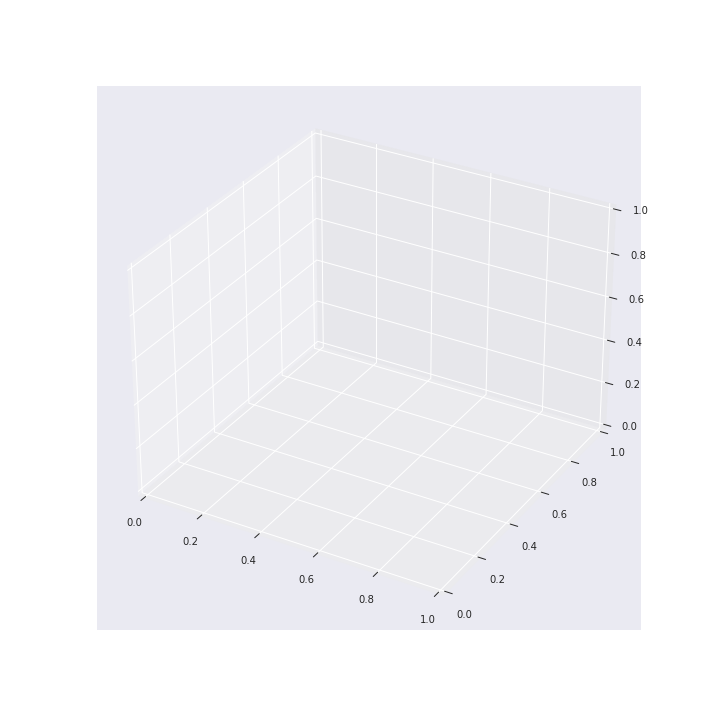

In [68]:
%matplotlib widget

plt.close()

ts_fig = plt.figure(figsize = (10, 10))
ts_ax = ts_fig.add_subplot(111, projection='3d')

anim = animation.FuncAnimation(ts_fig, 
                                plot_3d, 
                                frames=angular_momentum.shape[1], 
                                interval=20, 
                                fargs=(angular_momentum, ts_ax, cluster_labels_AM, optimal_cluster_AM),
                                blit=True,
                                repeat_delay=200)

plt.show()